# Experiment: Precision–variance trade-off

Experiment (Fig. 2c): study the trade-off between sampling precision (1/error) and ensemble variance (e.g., mean operator norm / max eigenvalue of H) at fixed β as N increases.

In [4]:
import torch
import numpy as np
from scipy.linalg import expm

import quairkit as qkit
from quairkit.database import *
from quairkit.database import completely_mixed_computational, eye, x, y, z
from quairkit.qinfo import *

qkit.set_dtype('complex128')

In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from gibbs import *

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "font.family": "STIXGeneral",
    "mathtext.fontset": "cm",
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "lines.linewidth": 1.4,
    "lines.markersize": 4.5,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "xtick.major.size": 3.0,
    "ytick.major.size": 3.0,
    "axes.labelpad": 2,
})

## Experimental setting

Prepare Hamiltonian

In [7]:
n, hamiltonian = build_2d_heisenberg(3, 3, Jxy=0.05, Jz=0.04)
pauli_words = hamiltonian.pauli_words

In [8]:
error_level = 3
error = 10 ** (-error_level)

beta_fixed = 2

lb, si, sites = hamiltonian.decompose_with_sites()
xi = sum([abs(coef) for coef in lb])
C = (xi ** 2) / (error ** (2/3))   # fixed coefficient

num_p_points = 10
p_grid = np.linspace(1.0, 3.0, num_p_points)   # p in [1,3]
N_list = [int(np.ceil(C * (beta_fixed ** p))) for p in p_grid]

In [9]:
num_sample = 10

In [10]:
init_state = completely_mixed_computational(n)

## Compute data

In [11]:
def _pauli_str_to_matrix(pauli_str: str) -> torch.Tensor:
    r'''
    Convert a Pauli-word string (e.g., "IXZ") to its full matrix via Kronecker products.
    '''
    mats = []
    for s in pauli_str:
        if s == "X":
            mats.append(x())
        elif s == "Y":
            mats.append(y())
        elif s == "Z":
            mats.append(z())
        else:
            mats.append(eye())
    return nkron(*mats)

def _to_numpy(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x)

In [ ]:
records = []

save_dir = "data"
save_tag = "tradeoff"

for p, num_step in zip(p_grid, N_list):
    qkit.set_seed(20260107)
    list_state, sample_coef, sample_error, list_prob = algorithm1(
            n=n,
            beta=beta_fixed,
            hamiltonian=hamiltonian,
            error=error,
            num_sample=num_sample,
            num_step=num_step,
            init_state=init_state,
            save_dir="data",
            save_tag="tradeoff",
            save_state=True,
            save_compressed=True,
        )
    
    beta_tag = f"{float(beta_fixed):.6g}"
    err_tag  = f"{float(error):.6g}"
    path = os.path.join(
        save_dir,
        f"{save_tag}_b{beta_tag}_e{err_tag}_sample{int(num_sample)}_step{int(num_step)}.npz",
    )

    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing cached file: {path}")

    data = np.load(path, allow_pickle=True)
    sample_coef = data["sample_coef"]
    sample_error = data["sample_error"]
    
    se = _to_numpy(sample_error).reshape(-1)
    sc = _to_numpy(sample_coef)

    if sc.ndim == 1:
        sc2 = sc[None, :]
    else:
        sc2 = sc.reshape(sc.shape[0], -1)

    err_max = float(np.max(se))
    err_max = 1 / err_max
    
    list_eign_max = []
    device = qkit.get_device()
    
    coef = torch.as_tensor(sample_coef, device=device, dtype=torch.complex128)

    # ---- Precompute Pauli operators OPS[k] ----
    OPS = torch.stack(
        [_pauli_str_to_matrix(w)
        for w in pauli_words],
        dim=0
    )
    # OPS: (13, D, D)

    # ---- Batch construction of Hamiltonians ----
    # H_b = sum_k coef[b, k] * OPS[k]
    H = torch.einsum("bk,kij->bij", coef, OPS)
    H = (H + H.conj().transpose(-1, -2)) / 2

    eign_hvals = torch.linalg.eigvalsh(H)
    eign_hvals = eign_hvals.real
    eign_max = torch.max(eign_hvals, dim=-1).values

    eign_max_np = _to_numpy(eign_max).reshape(-1)  # (num_sample,)

    records.append({
        "p": float(p),
        "N": int(num_step),
        "err_max": err_max,
        "Hmax_mean": float(eign_max_np.mean()),
        "Hmax_std":  float(eign_max_np.std(ddof=1)) if eign_max_np.size > 1 else 0.0,
        "Hmax_sem":  float(eign_max_np.std(ddof=1) / np.sqrt(eign_max_np.size)) if eign_max_np.size > 1 else 0.0,
    })


In [ ]:
np.savez_compressed("data/tradeoff.npz", records=np.array(records, dtype=object))

We also provide saved data to save computation time.

In [ ]:
# records = np.load("data/tradeoff.npz", allow_pickle=True)["records"]

## Plot

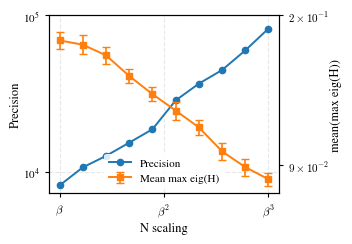

In [15]:
LEG_KW = dict(frameon=True, facecolor="white", edgecolor="none", framealpha=0.85)

ps      = np.array([r["p"]         for r in records], dtype=float)
err_max = np.array([r["err_max"]   for r in records], dtype=float)
y_mean  = np.array([r["Hmax_mean"] for r in records], dtype=float)
yerr    = np.array([r["Hmax_sem"]  for r in records], dtype=float)

fig, ax = plt.subplots(figsize=(3.375, 2.3))

ax.plot(ps, err_max, marker="o", color="C0", label="Precision")
ax.set_xlabel("N scaling", labelpad=2)     # keep aligned/compact
ax.set_ylabel("Precision", labelpad=1)
ax.set_yscale("log")
ax.grid(True, which="both", ls="--", alpha=0.3)

ax2 = ax.twinx()
ax2.errorbar(ps, y_mean, yerr=yerr,
             marker="s", linestyle="-",
             capsize=3, elinewidth=1.2, capthick=1.0, linewidth=1.4,
             color="C1", label="Mean max eig(H)")
ax2.set_ylabel("mean(max eig(H))", labelpad=1)
ax2.set_yscale("log")

# x tick labels: beta, beta^2, beta^3
ax.set_xticks([1, 2, 3])
ax.set_xticklabels([r"$\beta$", r"$\beta^2$", r"$\beta^3$"])

# keep your fixed y-ticks (optional)
try:
    ax.set_yticks([1e4, 1e5])
    ax2.set_yticks([9e-2, 2e-1])
    ax2.set_yticklabels([r"$9\times 10^{-2}$", r"$2\times 10^{-1}$"])
    ax.minorticks_off()
    ax2.minorticks_off()
except Exception:
    pass

# merged legend with white backdrop
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="lower center", **LEG_KW)

fig.tight_layout(pad=0.2)
plt.show()


---

In [16]:
qkit.print_info()


---------VERSION---------
quairkit: 0.5.0
torch: 2.9.1
numpy: 2.2.6
scipy: 1.15.2
matplotlib: 3.10.8
---------SYSTEM---------
Python version: 3.10.19
OS: Darwin
OS version: Darwin Kernel Version 23.5.0: Wed May  1 20:14:38 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6020
---------DEVICE---------
CPU: Apple M2 Pro
